# Modelling Wine Quality Based on Physicochemical Properties

## Introduction

Wine is a popular alcoholic beverage and is often rated based on its production quality and typicity, or how the wine can exhibit the style and traits of the region it’s from. Vinho verde is a wine that comes from the northern regions of Portugal. The white variety is characterised by its fresh acidity with an alcoholic content of 8.5% - 11%. The red variety tastes tannic and is more tart. Moreover, it tends to be lower in alcohol content, around 8%. 


For our project, we would like to answer the question: can we predict the quality rating of a vinho verde wine based on its physicochemical properties using the dataset available to us? We will only be using one wine quality dataset, focusing on the red variety of vinho verde wine. The datasets contain information about the physicochemical properties of vinho verde wines with quality ratings given by experts. Columns in our dataset include: fixed acidity (g / dm^3), volatile acidity ( g / dm^3), citric acid (g / dm^3), residual sugar (g / dm^3), chlorides (g / dm^3), free sulfur dioxide (mg / dm^3), total sulfur dioxide (mg / dm^3), density (g / cm^3), pH, sulphates (g / dm^3), alcohol (% by volume) and quality (score between 0 and 10). We choose to use all the columns as preliminary variables to conduct our analysis because these variables affect the production and flavour of wine. 

It is important to note the limitations of this dataset. None of the white wines have a rating of 1,2 or 10. Meanwhile, none of the red wines have a rating of 1,2,9 or 10. Therefore, the lowest rating we would expect to predict for red vinho verde wine is 3, and the highest rating we would expect to predict for red vinho verde is 8.

Word Count: 500

### Dataset Attributions

- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


Data url : https://archive.ics.uci.edu/ml/datasets/Wine+Quality


## Methods

We will use both the K-nearest neighbours regression algorithm and the linear regression algorithm for our predicting model, in order to determine which model provides the most accurate predictions. Our methods include:

1. Load, clean, and wrangle our data using various wrangling functions

2. Randomly split the data into a training and testing set using `initial_split`, `training` and `testing`, and summarize the training data

3. Using the training set, we will determine which and how many of the predicting variables to use in our model by running a correlation plot, various visualizations, as well as a foward selection model. 

4. Create both models, tuning them if required:
- KNN requires standardization using `step_scale`, cross validation using `vfold_cv`, and K value tuning using `tune_grid`


5. Compute the accuracy of each model by testing it on the test data, and decide on the best model to use

6. Create a visualization of the best model using various visualization function

7. Predict the quality of a wine given an observation with an unknown rating

We hope to achieve an accuracy that is good enough to predict the quality of wine given an observation with an unknown rating. Our findings can help producers and sellers evaluate the quality of their products and can be useful for marketing or targeting consumer preferences. Relating to our work or wine quality classification, future analysis can explore what physicochemical variables affect wine quality the most.


## 1. Preliminary exploratory data analysis

In [1]:
# Libaries
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

#### a) Demonstrate that the dataset can be read from the web into R, Clean and wrangle your data into a tidy format

In [2]:
# Reading the data using read_delim 
# using read_delim and taking it from a url, however taking the csv file from the original website also works)

red_wine_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

red_data <- read_delim(red_wine_url, delim = ";")

red_data

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


#### b) Clean and Wrangle Data

In [3]:
# Changing column names so they have underscores using colnames, allowing us to be able to work with them

colnames(red_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                             "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                             "ph", "sulfates", "alcohol", "quality")


red_data

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


## 2. Split Data and Summarize

#### a) split data into training and testing

In [4]:
#Let's split our data into testing and training data, and look at the training data so we can apply exploraty analysis
#Using set seed to allow for reproducibility 

set.seed(69)
red_split<-initial_split(red_data, prop=0.75, strata = quality)
red_train<-training(red_split)
red_test<-testing(red_split)

red_train

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.2,0.60,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5
5.9,0.55,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
6.0,0.31,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


#### b) Summarize the data into tables and visualizations

In [5]:
#Let's summarize the data by figuring out how many wines are in each class (each quality ranking)
set.seed(69)
red_wine_quality_count<- red_train %>% 
                       group_by(quality) %>%
                       summarize(count = n())
red_wine_quality_count


`summarise()` ungrouping output (override with `.groups` argument)



quality,count
<dbl>,<int>
3,8
4,40
5,510
6,479
7,151
8,12


## 3. Predictor Variable Selection (KNN Regression)

#### a) Let's make some visualizations to see how different variables affect eachother, and how they relate to the class (quality)

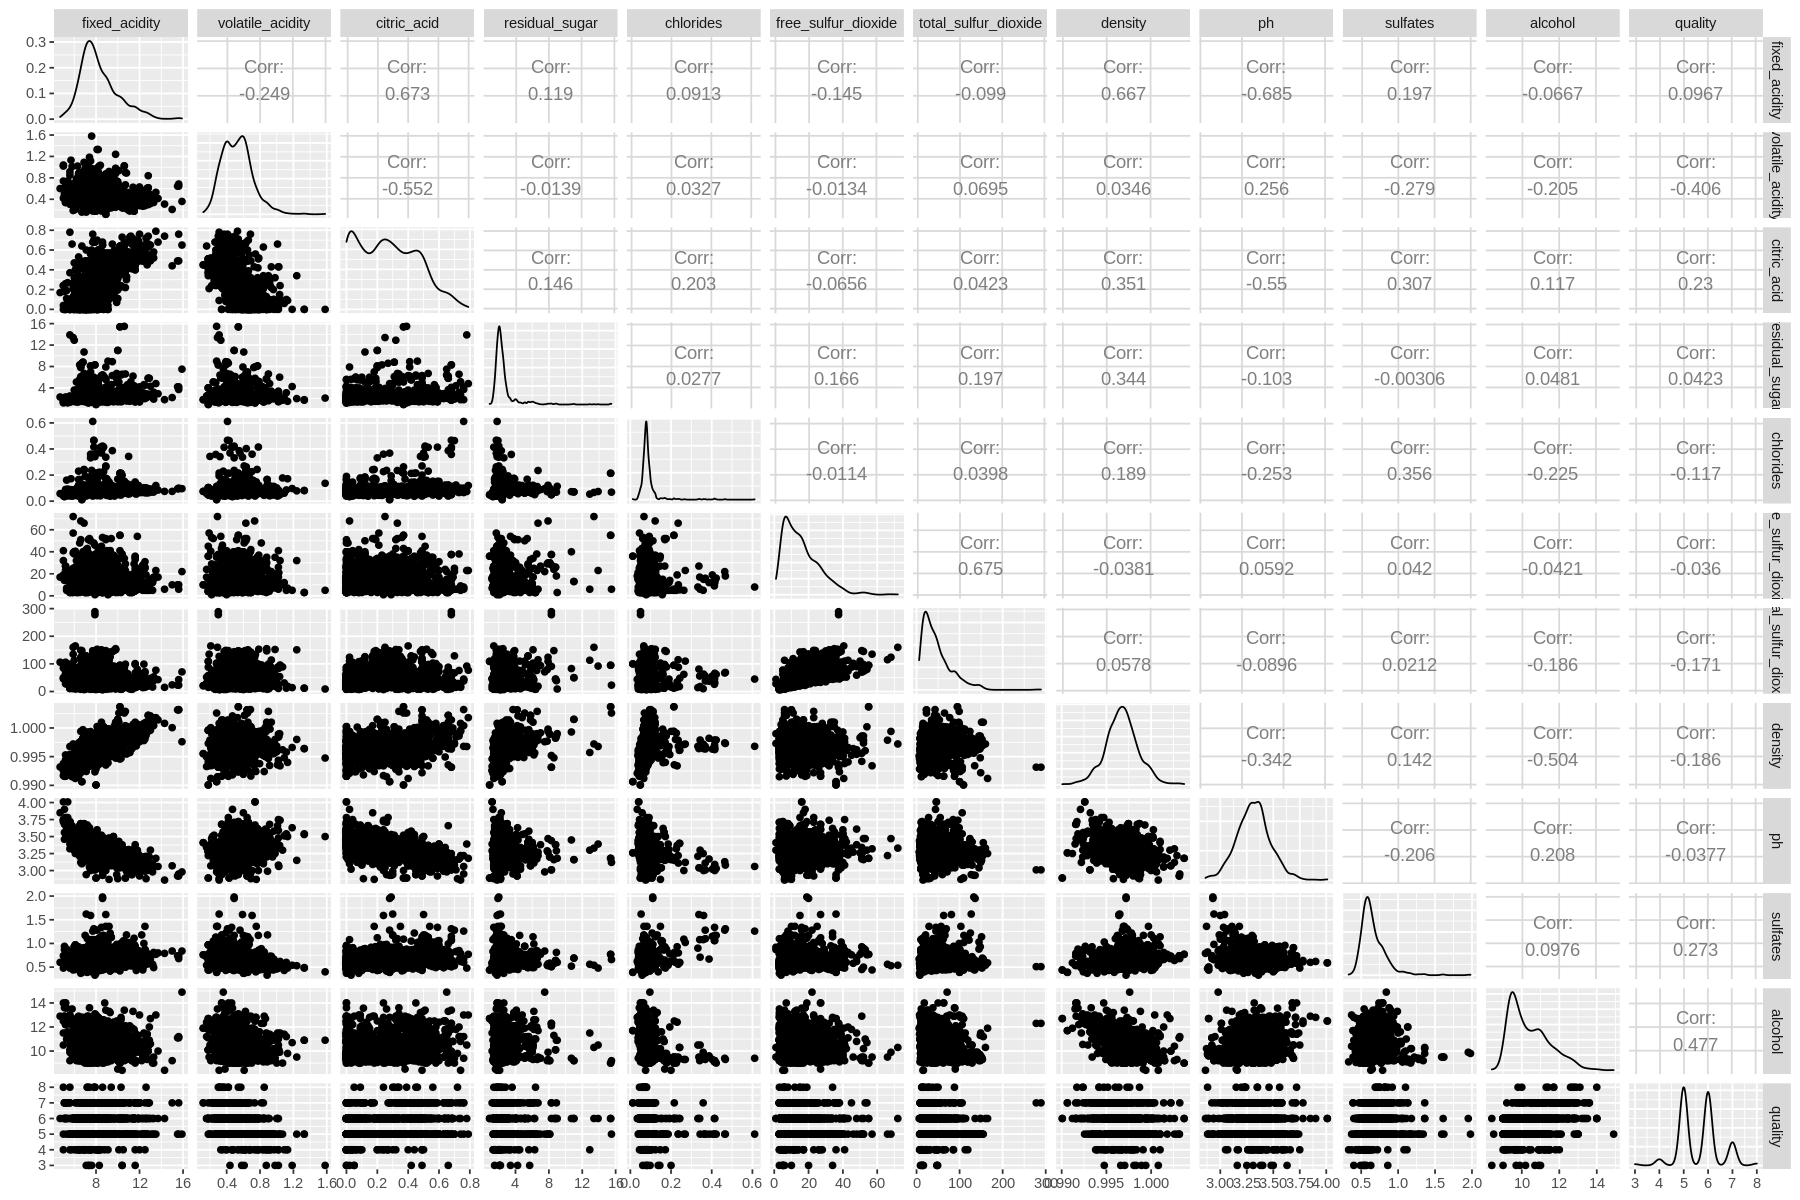

In [6]:
#Let's use the ggpairs function to determine which variables are related to quality the most, to begin deciding what we want to use as predictor variables

set.seed(69)
options(repr.plot.height = 10, repr.plot.width = 15)

red_plot_intro<- ggpairs(red_train)
red_plot_intro



As we can see, for red wines, alcohol (0.485), sulfates (0.255), citric acidity (0.214), and volatile acidity (-0.384) have the highest correlation coefficients.

Let's look at an exploratory visualization of the two most strongly correlated variables and quality:


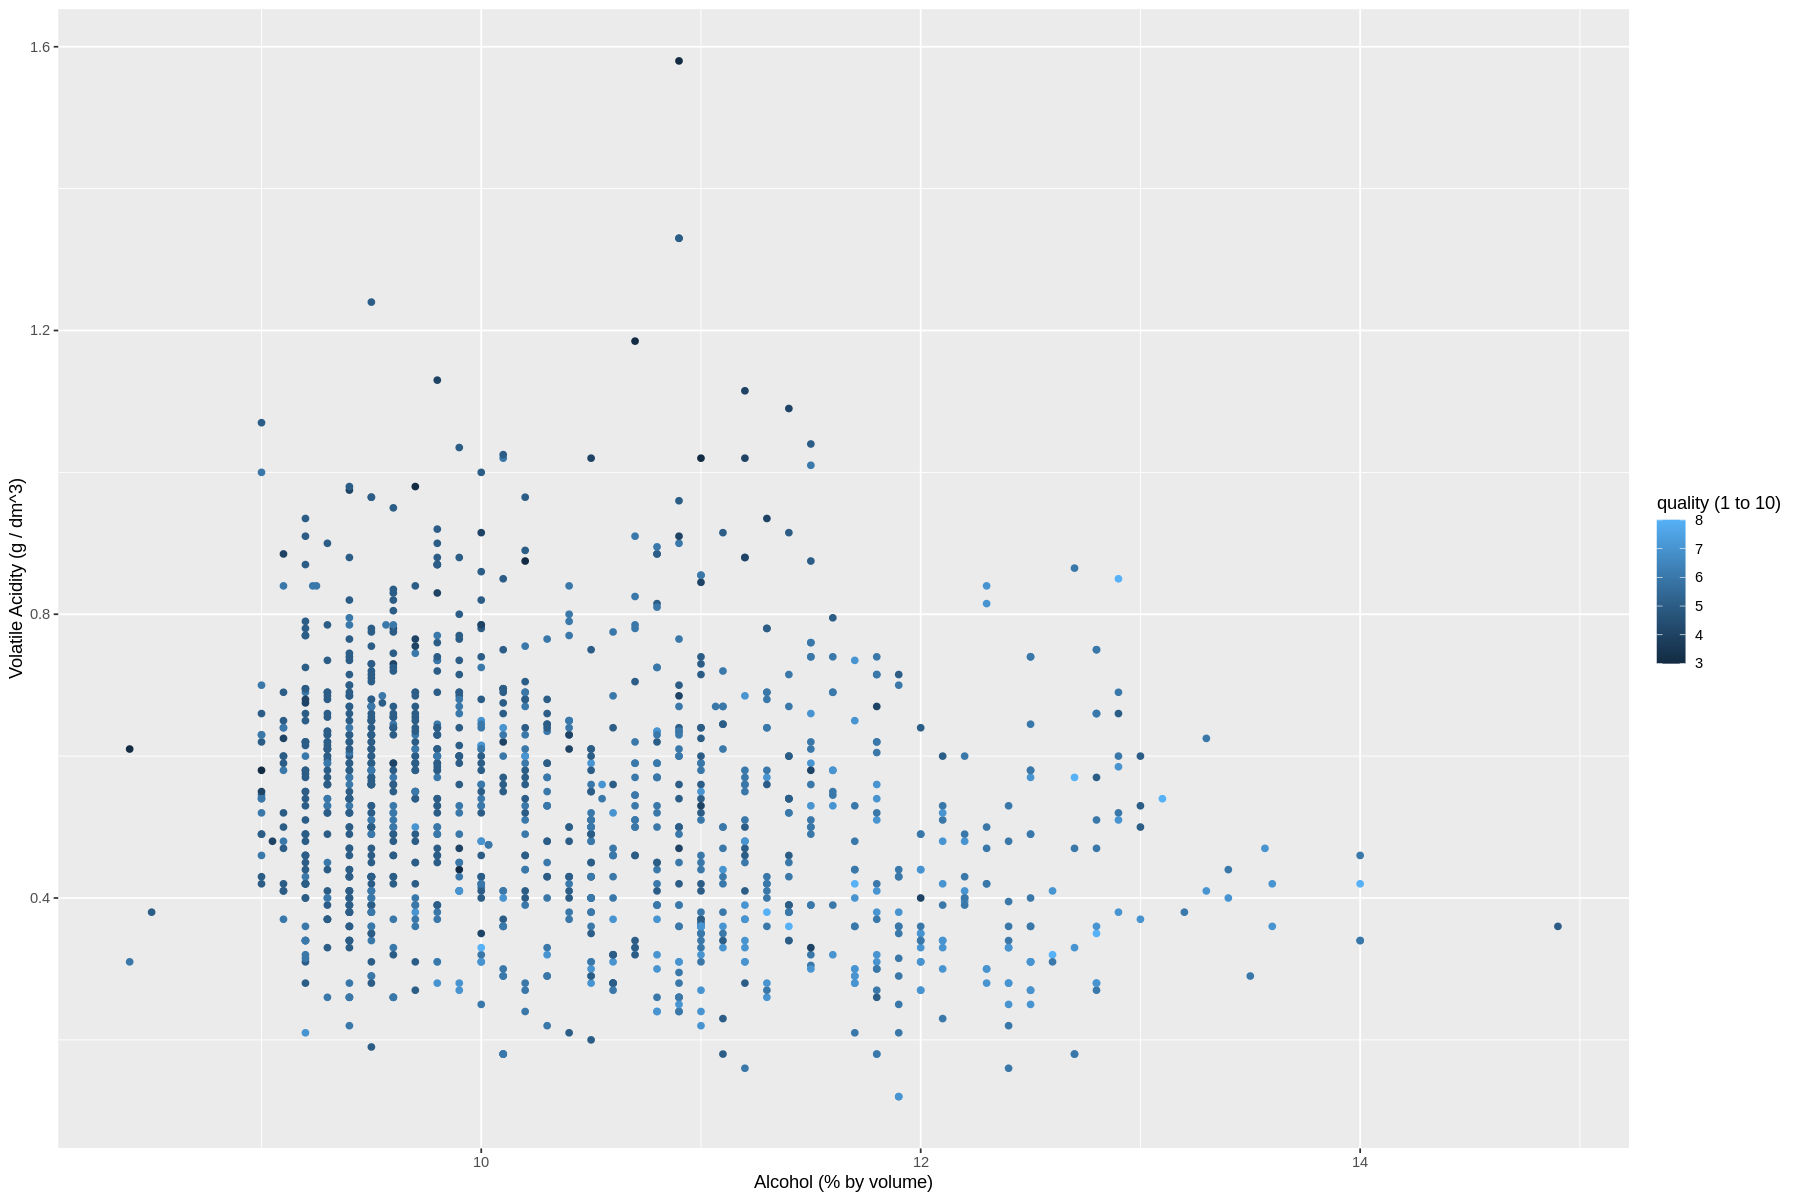

In [7]:
#Create a ggplot between alcohol and volatile acidity, using quality as color

red_plot_initial<-ggplot(red_train, aes(x = alcohol, y = volatile_acidity, color = quality))+
geom_point()+
labs(x = "Alcohol (% by volume)", y = "Volatile Acidity (g / dm^3)", color = "quality (1 to 10)" )

red_plot_initial

We can see that increasing alcohol shows a positive correlation with quality level. It is a little harder to visualize but there also seems to be a weak negative relationship between volatile acidity and quality

#### b) Apply forward selection to figure out the best selection of predictors based on the highest correlating variables from above

In [8]:
#Let's now go through forward selection to figure out the best selection of predictors

#Select the variables mentioned above (the top 4 variables for each wine level) and extract column names
wine_r_subset <- red_train %>%
  select(quality, 
         alcohol, 
         sulfates, 
         citric_acid, 
         volatile_acidity)

names <- colnames(wine_r_subset %>%
                  select(-quality))

wine_r_subset

quality,alcohol,sulfates,citric_acid,volatile_acidity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,9.8,0.68,0.00,0.88
5,9.8,0.65,0.04,0.76
5,9.4,0.56,0.00,0.70
⋮,⋮,⋮,⋮,⋮
5,10.5,0.58,0.08,0.60
6,11.2,0.76,0.10,0.55
6,11.0,0.66,0.47,0.31


In [9]:
#Now we will write the forward selection code

set.seed(69)
# create an empty tibble to store the results
RMSEs <- tibble(size = integer(),
model_string = character(),
rmse_value = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("regression")

# create a 5-fold cross-validation object
wine_r_vfold <- vfold_cv(wine_r_subset, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
# for every predictor still not added yet
rmses <- list()
models <- list()
for (j in 1:length(names)) {
# create a model string for this combination of predictors
preds_new <- c(selected, names[[j]])
model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

# create a recipe from the model string
wine_r_recipe <- recipe(as.formula(model_string),
data = wine_r_subset) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

# tune the KNN classifier with these predictors,
# and collect the rmse for the best K
rmse_ <- workflow() %>%
add_recipe(wine_r_recipe) %>%
add_model(knn_spec) %>%
tune_grid(resamples = wine_r_vfold, grid = 10) %>%
collect_metrics() %>%
filter(.metric == "rmse") %>%
summarize(mn = min(mean))
rmse_ <- rmse_$mn %>% unlist()

# add this result to the dataframe
rmses[[j]] <- rmse_
models[[j]] <- model_string
}
jstar <- which.min(unlist(rmses))
RMSEs <- RMSEs %>%
add_row(size = i,
model_string = models[[jstar]],
rmse_value = rmses[[jstar]])
selected <- c(selected, names[[jstar]])
names <- names[-jstar]}

best_predictors<- RMSEs %>%
arrange(rmse_value)

best_predictors

size,model_string,rmse_value
<int>,<chr>,<dbl>
4,quality ~ alcohol+volatile_acidity+sulfates+citric_acid,0.6446995
3,quality ~ alcohol+volatile_acidity+sulfates,0.6550689
2,quality ~ alcohol+volatile_acidity,0.6742619
1,quality ~ alcohol,0.7256284


The best combination of predictors to choose from is alcohol, volatile acidity, sulfates, and citric acid, 

[TODO] but since we are required to visualize our model, we will be selecting the best 2 predictors, which are alcohol and volatile acidity.

## 4. Creating our KNN and Linear Regression Models

##### Linear Regression (1 predictor)

In [10]:
set.seed(2022) 

# Create linear regression model specification
lm_spec1 <- linear_reg() %>% 
       set_engine("lm") %>%
       set_mode("regression")

# Create recipe for the model
red_recipe1 <- recipe(quality ~ alcohol, data = red_train)

# Put together in a workflow
red_fit1 <- workflow() %>%
                add_recipe(red_recipe1) %>%
                add_model(lm_spec1) %>%
                fit(data = red_train)

In [11]:
set.seed(2022) 

# Calculate 𝑅𝑀𝑆𝐸  to assess goodness of fit on credit_fit
lm_rmse1 <- red_fit1 %>%
         predict(red_train) %>%
         bind_cols(red_train) %>%
         metrics(truth = quality, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmse1

[1] 0.7089734

In [12]:
set.seed(2022) 

# Calculate  𝑅𝑀𝑆𝑃𝐸  using the test data

lm_rmspe1 <- red_fit1 %>%
         predict(red_test) %>%
         bind_cols(red_test) %>%
         metrics(truth = quality, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmspe1

[1] 0.7127751

`geom_smooth()` using formula 'y ~ x'



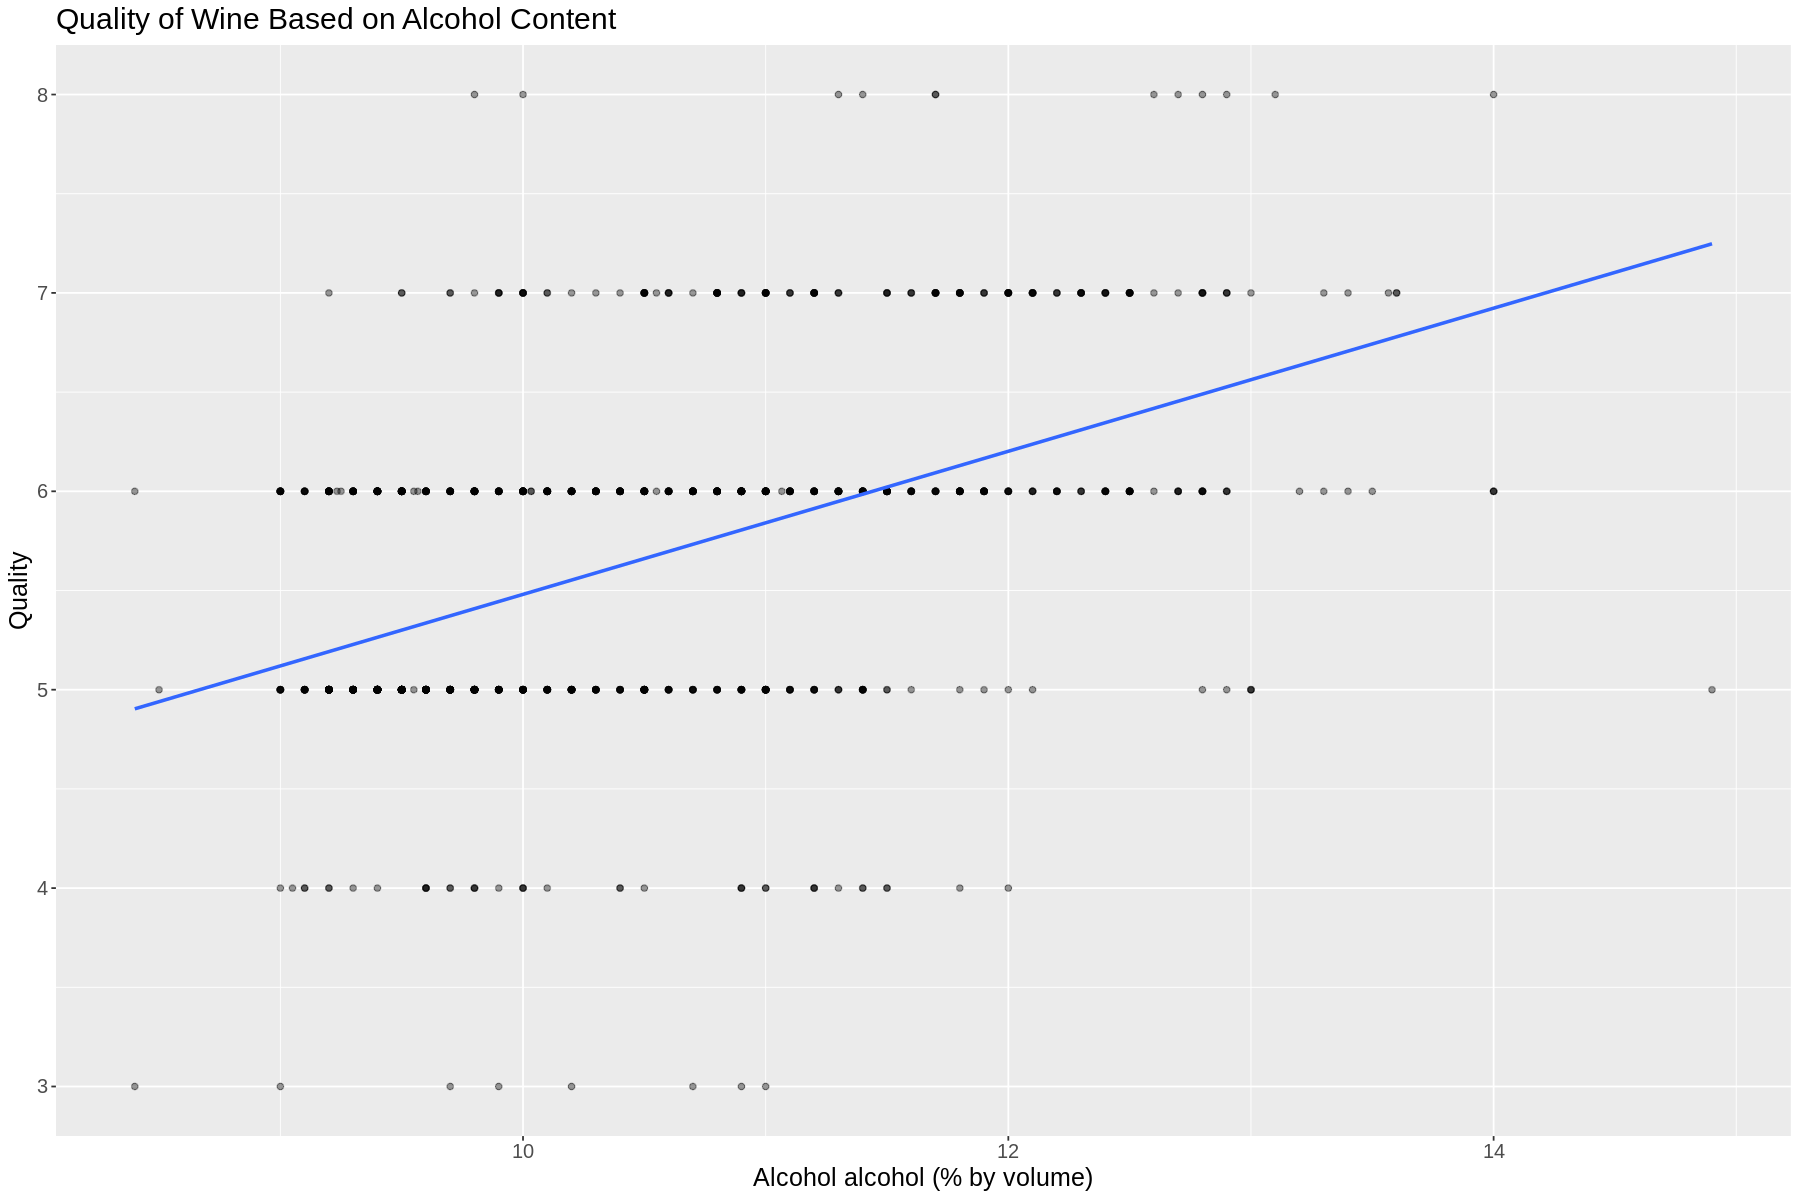

In [74]:
lm_plot_final <- ggplot(red_train, aes(x = alcohol, y = quality)) +
  geom_point(alpha = 0.4) +
  xlab("Alcohol alcohol (% by volume)") +
  ylab("Quality") +
  ggtitle("Quality of Wine Based on Alcohol Content") +
  geom_smooth(method = "lm", se = FALSE) +
  theme(text = element_text(size = 15))

lm_plot_final

##### Linear Regression (4 predictors)

In [17]:
set.seed(2022) 

# Create linear regression model specification
lm_spec2 <- linear_reg() %>% 
       set_engine("lm") %>%
       set_mode("regression")

# Create recipe for the model
red_recipe2 <- recipe(quality ~ alcohol + sulfates + citric_acid + volatile_acidity, data = red_train)

# Put together in a workflow
red_fit2 <- workflow() %>%
                add_recipe(red_recipe2) %>%
                add_model(lm_spec2) %>%
                fit(data = red_train)

In [18]:
set.seed(2022) 

# Calculate 𝑅𝑀𝑆𝐸  to assess goodness of fit on credit_fit
lm_rmse2 <- red_fit2 %>%
         predict(red_train) %>%
         bind_cols(red_train) %>%
         metrics(truth = quality, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmse2

[1] 0.6505561

In [23]:
set.seed(2022) 

# Calculate  𝑅𝑀𝑆𝑃𝐸  using the test data

lm_rmspe2 <- red_fit2 %>%
         predict(red_test) %>%
         bind_cols(red_test) %>%
         metrics(truth = quality, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmspe2

[1] 0.6798631

##### KNN Regression (1 predictor)

In [ ]:
library(themis)

ups_recipe <- recipe(Class ~ ., data = rare_cancer) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

In [34]:
set.seed(420) # DO NOT REMOVE

# Create recipe
red_knn_recipe1 <- recipe(quality ~ alcohol, data = red_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())

# Create a model specification
red_knn_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                      set_engine("kknn") %>%
                      set_mode("regression")

# Create 5-fold cross-validation object
red_vfold1 <- vfold_cv(red_train, v = 5, strata = quality)

# Put the recipe and model specification together in a workflow.
red_knn_workflow1 <- workflow() %>%
                        add_recipe(red_knn_recipe1) %>%
                        add_model(red_knn_spec1)

# Run cross-validation for a grid of numbers of neighbors ranging from 1 to 400
gridvals1 <- tibble(neighbors = seq(1, 200))

red_knn_results1 <- red_knn_workflow1 %>%
                       tune_grid(resamples = red_vfold1, grid = gridvals1) %>%
                       collect_metrics() 

#select the value of k resulting in best RMSE
kmin1 <- red_knn_results1 %>%
               filter(.metric == 'rmse') %>%
               filter(mean == min(mean))  %>% 
               pull(neighbors)

#retrain the model using that final k, predict on held-out data
red_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin1) %>%
  set_engine("kknn") %>%
  set_mode("regression")

red_fit1 <- workflow() %>%
  add_recipe(red_knn_recipe1) %>%
  add_model(red_spec1) %>%
  fit(data = red_train)

knn_rmspe1 <- red_fit1 %>%
  predict(red_test) %>%
  bind_cols(red_test) %>%
  metrics(truth = quality, estimate = .pred)%>%
  filter(.metric == 'rmse') %>%
  pull(.estimate) 

knn_rmspe1

[1] 0.710375

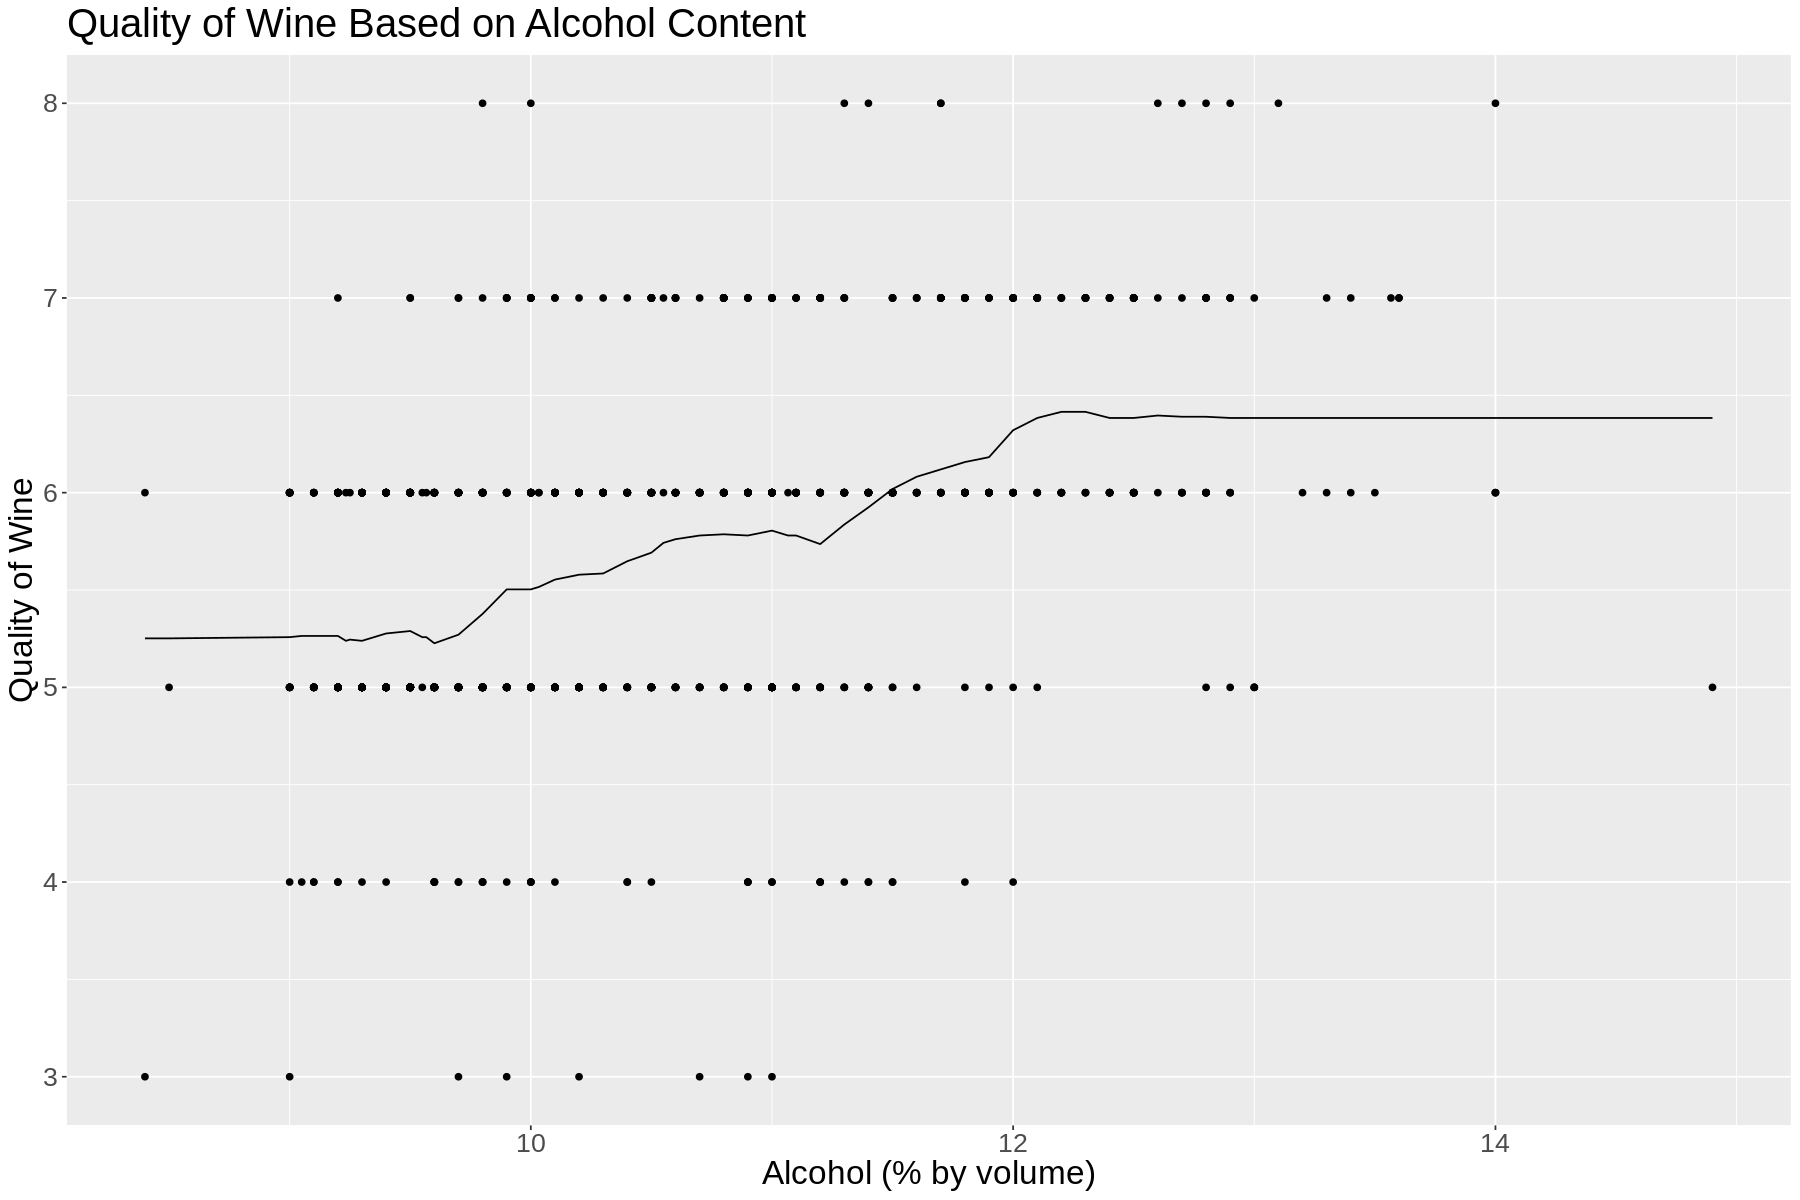

In [62]:
red_predict <- red_fit1 %>%
    predict(red_train) %>%
    bind_cols(red_train) %>%
    ggplot(aes(x = alcohol, y = quality)) +
    geom_point() +
    geom_line(mapping = aes(x = alcohol, .pred)) +
    xlab("Alcohol (% by volume)") +
    ylab("Quality of Wine") +
    ggtitle("Quality of Wine Based on Alcohol Content") +
    theme(text = element_text(size = 20))

red_predict

##### KNN Regression (4 predictors)

In [33]:
set.seed(420) # DO NOT REMOVE

# Create recipe
red_knn_recipe2 <- recipe(quality ~ alcohol + sulfates + citric_acid + volatile_acidity, data = red_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())

# Create a model specification
red_knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                      set_engine("kknn") %>%
                      set_mode("regression")

# Create 5-fold cross-validation object
red_vfold2 <- vfold_cv(red_train, v = 5, strata = quality)

# Put the recipe and model specification together in a workflow.
red_knn_workflow2 <- workflow() %>%
                        add_recipe(red_knn_recipe2) %>%
                        add_model(red_knn_spec2)

# Run cross-validation for a grid of numbers of neighbors ranging from 1 to 400
gridvals2 <- tibble(neighbors = seq(1, 200))

red_knn_results2 <- red_knn_workflow2 %>%
                       tune_grid(resamples = red_vfold1, grid = gridvals2) %>%
                       collect_metrics() 

#select the value of k resulting in best RMSE
kmin2 <- red_knn_results2 %>%
               filter(.metric == 'rmse') %>%
               filter(mean == min(mean))  %>% 
               pull(neighbors)

#retrain the model using that final k, predict on held-out data
red_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin2) %>%
  set_engine("kknn") %>%
  set_mode("regression")

red_fit2 <- workflow() %>%
  add_recipe(red_knn_recipe2) %>%
  add_model(red_spec2) %>%
  fit(data = red_train)


# predict
knn_rmspe2 <- red_fit2 %>%
  predict(red_test) %>%
  bind_cols(red_test) %>%
  metrics(truth = quality, estimate = .pred)%>%
  filter(.metric == 'rmse') %>%
  pull(.estimate) 

knn_rmspe2

[1] 0.6712432